# Телеком: исследование оттока клиентов

Сравним распределения величин ежемесячных платежей (`MonthlyCharges`) всех клиентов и тех, кто ушёл. 

Сравним поведение клиентов этих двух групп. Посмотрим на долю пользователей интернета и телефонной связи.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:

contract = pd.read_csv('final_provider/contract.csv')
personal = pd.read_csv('final_provider/personal.csv')
internet = pd.read_csv('final_provider/internet.csv')
phone = pd.read_csv('final_provider/phone.csv')

In [3]:
datas = {'contract' : contract,
         'personal' : personal,
         'internet' : internet,
         'phone' : phone}

In [4]:
#таблица с долей пропусков
def percent_nan(data):
    isna_data = pd.DataFrame(data.isna().sum())
    isna_data.columns = ['nan']
    isna_data['rate'] = isna_data['nan']/len(data)
    return(isna_data.style.format("{:.2%}", subset='rate'))

In [5]:
def get_df_info(df):
    display(df.head(5))
    display(df.info())
    display(df.describe())
    display(percent_nan(df))

In [6]:
for key in datas.keys():
    print('Информация о таблице:', key)
    get_df_info(datas[key])

Информация о таблице: contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,nan,rate
customerID,0,0.00%
BeginDate,0,0.00%
EndDate,0,0.00%
Type,0,0.00%
PaperlessBilling,0,0.00%
PaymentMethod,0,0.00%
MonthlyCharges,0,0.00%
TotalCharges,0,0.00%


Информация о таблице: personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,nan,rate
customerID,0,0.00%
gender,0,0.00%
SeniorCitizen,0,0.00%
Partner,0,0.00%
Dependents,0,0.00%


Информация о таблице: internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2925-MXLSX,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,nan,rate
customerID,0,0.00%
InternetService,0,0.00%
OnlineSecurity,0,0.00%
OnlineBackup,0,0.00%
DeviceProtection,0,0.00%
TechSupport,0,0.00%
StreamingTV,0,0.00%
StreamingMovies,0,0.00%


Информация о таблице: phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,3212-KXOCR,No
freq,1,3390


,nan,rate
customerID,0,0.00%
MultipleLines,0,0.00%


## Подготовка данных

Приведение значений столбцов к необходимым форматам:
- **`contract`** `TotalCharges` - **float64**
- **`contract`** `BeginDate` и `EndDate` - **datetime**

In [7]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], downcast='float', errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d', errors='coerce')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

Создадим дополнительный признак указывающий на время пользования услугами опратора.

In [8]:
END_DAY = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
def get_life_time(data):
    begin_date = data['BeginDate']
    end_date = data['EndDate']
    
    def diff_days(d1, d2):
        return (d1 - d2).days
#        return (d1.year - d2.year) * 12 + d1.month - d2.month
        
    
    if end_date is pd.NaT:
        
        life_time = diff_days(END_DAY, begin_date)
    else:
        life_time = diff_days(end_date, begin_date)
    return life_time

In [9]:
contract['LifeTime'] = contract.apply(get_life_time, axis=1)

Дополнительные признаки, указывающие на наличие подключения к интернету и к телефонной линии.

In [10]:
internet['IsInternet'] = np.full(internet.shape[0], 'Yes')
phone['IsPhone'] = np.full(phone.shape[0], 'Yes')

Преобразуем дату оканчания договора в бинарный признак.

In [11]:
#бинаризация целевого признака
contract['EndDate'] = np.where(contract['EndDate'].isna(), 'client', 'churn')

Объединим все таблицы в одну общую.

In [12]:
data = contract.set_index('customerID').join(personal
                                             .set_index('customerID')).join(internet
                                                                            .set_index('customerID').join(phone.set_index('customerID'), how='outer'))

Так как не все клиенты используют и телефонную связь и интернет, в итоговой таблице образовались пропуски. Заменим их на значения 0

In [13]:
data['IsInternet'] = data['IsInternet'].fillna('No')
data['IsPhone'] = data['IsPhone'].fillna('No')

In [14]:
data = data.fillna(0)

In [15]:
get_df_info(data)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,IsInternet,MultipleLines,IsPhone
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,client,Month-to-month,Yes,Electronic check,29.85,29.850000,31,Female,0,...,DSL,No,Yes,No,No,No,No,Yes,0,No
5575-GNVDE,2017-04-01,client,One year,No,Mailed check,56.95,1889.500000,1036,Male,0,...,DSL,Yes,No,Yes,No,No,No,Yes,No,Yes
3668-QPYBK,2019-10-01,churn,Month-to-month,Yes,Mailed check,53.85,108.150002,61,Male,0,...,DSL,Yes,Yes,No,No,No,No,Yes,No,Yes
7795-CFOCW,2016-05-01,client,One year,No,Bank transfer (automatic),42.30,1840.750000,1371,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,Yes,0,No
9237-HQITU,2019-09-01,churn,Month-to-month,Yes,Electronic check,70.70,151.649994,61,Female,0,...,Fiber optic,No,No,No,No,No,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 22 columns):
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float32
LifeTime            7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
IsInternet          7043 non-null object
MultipleLines       7043 non-null object
IsPhone       

None

,MonthlyCharges,TotalCharges,LifeTime,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734375,985.996166,0.162147
std,30.090047,2266.794434,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.549988,273.000000,0.000000
50%,70.350000,1394.550049,883.000000,0.000000
75%,89.850000,3786.599976,1676.000000,0.000000
max,118.750000,8684.799805,2191.000000,1.000000


,nan,rate
BeginDate,0,0.00%
EndDate,0,0.00%
Type,0,0.00%
PaperlessBilling,0,0.00%
PaymentMethod,0,0.00%
MonthlyCharges,0,0.00%
TotalCharges,0,0.00%
LifeTime,0,0.00%
gender,0,0.00%
SeniorCitizen,0,0.00%


## Анализ поведения клиентов

### Исследование распределения ежемесячной оплаты клиентов

In [16]:
churn = data.loc[data['EndDate']=='churn']

In [17]:
def analisis(data1, data2):
  
    sns.set(style="white", palette="muted", color_codes=True)
    f, ax = plt.subplots(figsize=(8, 8), dpi= 80)
    plt.title('Распределение ежемесячных платежей', fontdict={'fontsize':14})
    sns.distplot(data1['MonthlyCharges'], label="Клиенты", kde_kws={'linewidth':1})
    sns.distplot(data2['MonthlyCharges'], label="Отток", kde_kws={'linewidth':1})
    plt.legend()
    plt.show()
    index = ['Mean', 'Min', 'Max', 'Mediana', '25%', '75%']
    clients_stat = []
    clients_stat.append(np.mean(data1['MonthlyCharges']))
    clients_stat.append(np.min(data1['MonthlyCharges']))
    clients_stat.append(np.max(data1['MonthlyCharges']))
    clients_stat.append(np.median(data1['MonthlyCharges']))
    clients_stat.append(np.quantile(data1['MonthlyCharges'], .25))
    clients_stat.append(np.quantile(data1['MonthlyCharges'], .75))
    churn_stat = []
    churn_stat.append(np.mean(data2['MonthlyCharges']))
    churn_stat.append(np.min(data2['MonthlyCharges']))
    churn_stat.append(np.max(data2['MonthlyCharges']))
    churn_stat.append(np.median(data2['MonthlyCharges']))
    churn_stat.append(np.quantile(data2['MonthlyCharges'], .25))
    churn_stat.append(np.quantile(data2['MonthlyCharges'], .75))
    statistics = pd.DataFrame(clients_stat, index=index, columns=['Clients'])
    statistics['Churn'] = churn_stat
    print('Распределение ежемесячных платежей')
    display(statistics)

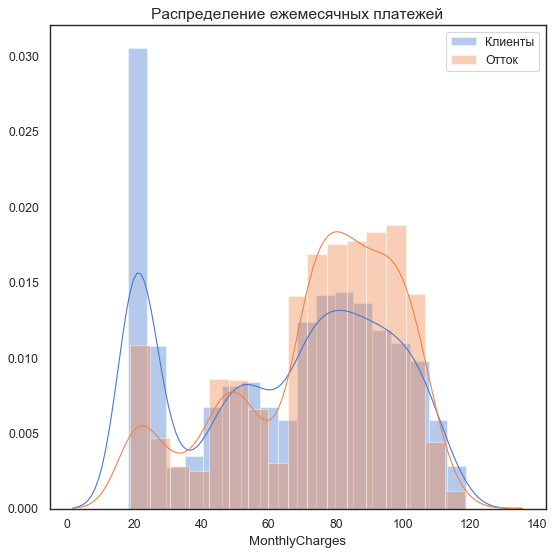

Распределение ежемесячных платежей


,Clients,Churn
Mean,64.761692,74.441332
Min,18.250000,18.850000
Max,118.750000,118.350000
Mediana,70.350000,79.650000
25%,35.500000,56.150000
75%,89.850000,94.200000


In [18]:
analisis(data, churn)

По графику можно заметить что отток клиентов больше среди тех у кого ежемесячная оплата в промежутке от 70 до 110.

Проверим гипотезу что средняя помесячная оплата отточных клиентов не отличается от всех.
В нулевой гипотезе (H0) предположим что средняя помесячная оплата равна. Тогда альтренативная гипотеза будет звучать как: Средняя оплата отличается.

In [19]:
alpha = .01 #объём выборок больше 100. Критический уровень статистической значимости 1% даст более точные результаты.

results = st.ttest_ind(
    data['MonthlyCharges'], 
    churn['MonthlyCharges'], equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.672642398172353e-45
Отвергаем нулевую гипотезу


По результатам статистического теста отвергаем нулевую гипотезу. 

### Исследование поведения клиентов

In [20]:
def get_pie(data, title):
    def label_function(val):
        return f'{val / 100 * len(data):.0f}\n{val:.0f}%'
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    fig.suptitle(title, fontdict={'fontsize':22})
    data.groupby('IsInternet').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                      colors=['tomato', 'gold'], ax=ax1)
    data.groupby('IsPhone').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                     colors=['violet', 'skyblue'], ax=ax2)
    ax1.set_xlabel('Internet', size=20)
    ax2.set_xlabel('Phone', size=20)
    ax1.set_ylabel(' ', size=20)
    ax2.set_ylabel(' ', size=20)
    plt.tight_layout()
    plt.show()

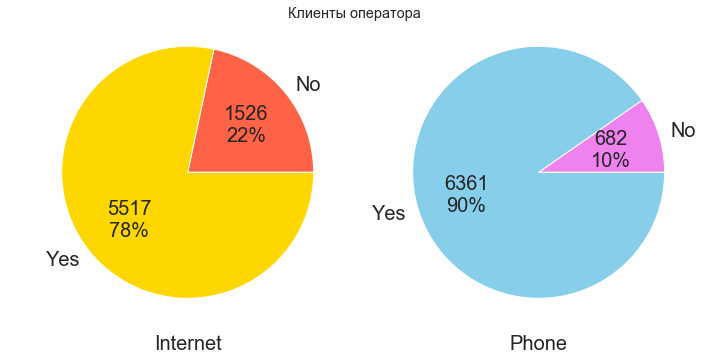

In [21]:
get_pie(data, 'Клиенты оператора')

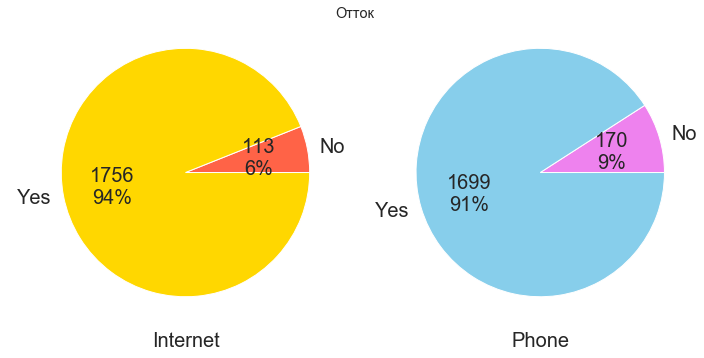

In [22]:
get_pie(churn, 'Отток')

Из круговой диаграммы видно, что среди тех кто решил перестать пользоваться услугами оператора, больше тех кто пользовался интернетом. 

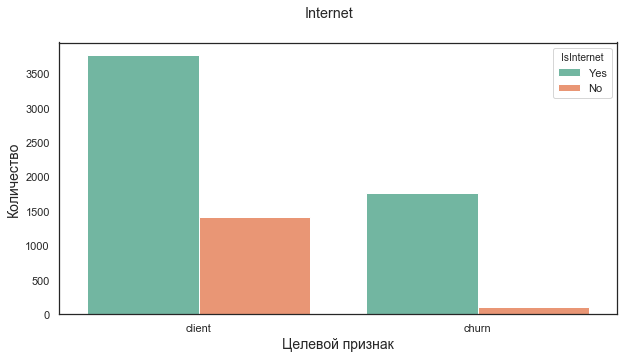

In [23]:
sns.set(style="white", palette="Set2", color_codes=True)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Internet', fontdict={'fontsize':22})
ax = sns.countplot(x='EndDate', hue="IsInternet", data=data)

ax.set_xlabel('Целевой признак', size=14)
ax.set_ylabel('Количество', size=14)
plt.show()

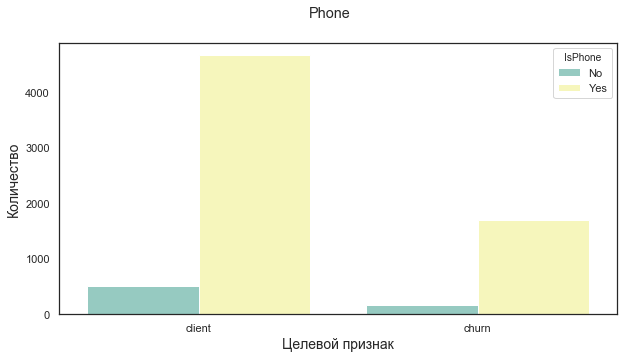

In [24]:
sns.set(style="white", palette="Set3", color_codes=True)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Phone', fontdict={'fontsize':22})
ax = sns.countplot(x='EndDate', hue="IsPhone", data=data)
ax.set_xlabel('Целевой признак', size=14)
ax.set_ylabel('Количество', size=14)
plt.show()

### Выводы:
- По графику распределения ежемесячных платежей можно заметить что отток клиентов больше среди тех у кого ежемесячная оплата в промежутке от 70 до 110.
- По результатам статистического теста отвергаем нулевую гипотезу о том что средняя ежемесячная оплата тех кто перестал пользоваться услугами оператора не обличается от остальных клиентов. 
- Среди ушедших пользователей меньше тех кто не пользовался интернетом (6% против 22% среди всех клиентов)